In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Filter all warnings
warnings.filterwarnings("ignore")


In [2]:
# list of 8 applications in dataset
classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
           'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
              'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
                     'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
                            'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
                            'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']
classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
threshold_score = 0.99

In [6]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

def count_succ_classes(class_list):
    return len(class_list)

### Find the classes having a score > threshold in every model
def find_successful_classes(c_report):
    c_keys = c_report.keys()
    classes_succ = []
    for key in c_keys:
        if key not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg']:
            if c_report[key]['f1-score'] > threshold_score:
                classes_succ.append(key)
    return classes_succ

### Get the score of 3 Classes
def get_score_of_classes(c_report):
    c_keys = c_report.keys()
    for key in c_keys:
        if key == class_name:
            return c_report[key]['f1-score']


In [7]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [8]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    
# solution_colors = {'Soter': '#6E7E99','Mousika': '#ffbb78', 'Planter': 'teal', 'pForest': '#8A9961', 
                    #    'NetBeacon': '#1f77b4', 'Flowrest': '#E06B5A', 'Jewel': '#A95C68'}
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
        plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.title(fig_title)
    plt.legend()
    plt.show()

## WITH LIMITATION

### N=2

In [9]:
model_analysis_limitation_N2 = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_2pkts_FEATSALL_FL.csv', sep=';')

In [10]:
len(model_analysis_limitation_N2)

32241

In [45]:
# model_analysis_limitation_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(4)

In [46]:
# model_analysis_limitation_N2[(model_analysis_limitation_N2['tree'] == 1) & (model_analysis_limitation_N2['no_feats'] < 16)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [47]:
# model_analysis_limitation_N2[(model_analysis_limitation_N2['tree'] == 2) & (model_analysis_limitation_N2['no_feats'] < 10)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [48]:
# model_analysis_limitation_N2[(model_analysis_limitation_N2['tree'] == 3) & (model_analysis_limitation_N2['no_feats'] < 8)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [49]:
# model_analysis_limitation_N2[(model_analysis_limitation_N2['tree'] == 4) & (model_analysis_limitation_N2['no_feats'] < 6)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [50]:
# model_analysis_limitation_N2[(model_analysis_limitation_N2['tree'] == 5) & (model_analysis_limitation_N2['no_feats'] < 5)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

### N=3

In [10]:
model_analysis_limitation_N3 = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_FEATSALL_FL.csv', sep=';')

In [11]:
model_analysis_limitation_N3.sort_values(by='Weighted_f1_FL', ascending=False).head(5)

,depth,tree,no_feats,N_Leaves,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,pkt_macro_f1,pkt_weighted_f1,flw_macro_f1,flw_weighted_f1,F1_macro,F1_weighted,num_samples,Macro_F1_PL,Weighted_F1_PL
26914,15,34,7,500,0.748922,0.893412,0.894306,"['tcp.window_size_value', 'ip.len', 'tcp.hdr_l...",0.713728,0.870924,0.841354,0.941796,0.744005,0.890571,1488248,0.823310,0.919229
28526,15,36,7,500,0.748763,0.893186,0.894045,"['tcp.window_size_value', 'ip.len', 'tcp.hdr_l...",0.714626,0.870420,0.839680,0.941415,0.744104,0.890100,1488248,0.822315,0.915269
27720,15,35,7,500,0.748558,0.893185,0.894116,"['tcp.window_size_value', 'ip.len', 'tcp.hdr_l...",0.713002,0.870455,0.841203,0.941409,0.743230,0.890142,1488248,0.822541,0.915063
30944,15,39,7,500,0.752172,0.892888,0.893259,"['tcp.window_size_value', 'ip.len', 'tcp.hdr_l...",0.713530,0.870071,0.850302,0.942328,0.745624,0.890087,1488248,0.823684,0.915513
16684,23,21,7,500,0.755063,0.892655,0.893445,"['tcp.window_size_value', 'ip.len', 'srcport',...",0.711663,0.867312,0.840556,0.938130,0.744210,0.886903,1488248,0.837196,0.898117


### N=4

In [10]:
model_analysis_limitation_N4 = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_4pkts_FEATSALL_FL.csv', sep=';')

In [11]:
# model_analysis_limitation_N4.sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [19]:
# model_analysis_limitation_N4[(model_analysis_limitation_N4['tree'] == 1) & (model_analysis_limitation_N4['no_feats'] < 16)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [10]:
# model_analysis_limitation_N4[(model_analysis_limitation_N4['tree'] == 2) & (model_analysis_limitation_N4['no_feats'] < 10)].sort_values(by='Weighted_f1_FL', ascending=False).head(4)

In [23]:
# model_analysis_limitation_N4[(model_analysis_limitation_N4['tree'] == 3) & (model_analysis_limitation_N4['no_feats'] < 8)].sort_values(by='Weighted_f1_FL', ascending=False).head(4)

In [9]:
# model_analysis_limitation_N4[(model_analysis_limitation_N4['tree'] == 4) & (model_analysis_limitation_N4['no_feats'] < 6)].sort_values(by='Weighted_f1_FL', ascending=False).head(4)

In [25]:
# model_analysis_limitation_N4[(model_analysis_limitation_N4['tree'] == 5) & (model_analysis_limitation_N4['no_feats'] < 5)].sort_values(by='Weighted_f1_FL', ascending=False).head(4)

### N= 5

In [26]:
file_names_N5 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_5pkts_FEATSALL_FL.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_5pkts_FEATSALL_FL_OTHER.csv']

In [28]:
model_analysis_limitation_N5 = read_csv(file_names_N5)

In [32]:
# model_analysis_limitation_N5[(model_analysis_limitation_N5['tree'] == 1) & (model_analysis_limitation_N5['no_feats'] < 16)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [12]:
# model_analysis_limitation_N5[(model_analysis_limitation_N5['tree'] == 2) & (model_analysis_limitation_N5['no_feats'] < 10)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [13]:
# model_analysis_limitation_N5[(model_analysis_limitation_N5['tree'] == 3) & (model_analysis_limitation_N5['no_feats'] < 8)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [34]:
# model_analysis_limitation_N5[(model_analysis_limitation_N5['tree'] == 4) & (model_analysis_limitation_N5['no_feats'] < 6)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

## WITHOUT LIMITATION

#### N=5

In [11]:
file_names_N5 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N5_T1-10.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N5_T11-20.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N5_T21-30.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N5_T31-40.csv']

In [12]:
model_analysis_noLimit_N5 = read_csv(file_names_N5)

In [15]:
model_analysis_noLimit_N5.sort_values(by='Weighted_f1_FL', ascending=False).head(5)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,n_of_leaves,pkt_macro_f1,pkt_weighted_f1,flw_macro_f1,flw_weighted_f1,F1_macro,F1_weighted,num_samples,Macro_F1_PL,Weighted_F1_PL,Micro_F1_PL,cl_report_FL,cl_report_PL
2089,20,3,13,0.774119,0.906803,0.905512,"['ip.len', 'tcp.hdr_len', 'srcport', 'dstport'...","[11290, 11686, 8947]",0.780015,0.908619,0.874750,0.949699,0.794231,0.914077,1488248,0.852422,0.949429,0.945339,"{'Laptop': {'precision': 0.9776490938439789, '...","{'Laptop': {'precision': 0.982524241539151, 'r..."
4544,21,26,19,0.789893,0.906635,0.905048,"['ip.len', 'tcp.window_size_value', 'dstport',...","[9299, 14037, 10242, 13438, 9497, 10506, 9839,...",0.801760,0.903706,0.931674,0.962940,0.817114,0.911375,1488248,0.896777,0.965749,0.963929,"{'Laptop': {'precision': 0.973407057829994, 'r...","{'Laptop': {'precision': 0.9837930379364244, '..."
1385,23,32,22,0.786764,0.906613,0.905019,"['tcp.window_size_value', 'ip.len', 'dstport',...","[19746, 16641, 17405, 17965, 15418, 17145, 133...",0.797377,0.903229,0.906633,0.962522,0.812027,0.910899,1488248,0.908828,0.970295,0.969453,"{'Laptop': {'precision': 0.9726685055657549, '...","{'Laptop': {'precision': 0.9828945009708234, '..."
5316,20,7,16,0.784541,0.906578,0.904762,"['ip.len', 'tcp.window_size_value', 'dstport',...","[11227, 10541, 10334, 8548, 10270, 9557, 7487]",0.798105,0.904512,0.876779,0.956828,0.808967,0.911332,1488248,0.897087,0.961944,0.961363,"{'Laptop': {'precision': 0.9771159095366212, '...","{'Laptop': {'precision': 0.9836446018526737, '..."
2191,23,33,22,0.786191,0.906528,0.904944,"['tcp.window_size_value', 'ip.len', 'dstport',...","[19746, 16641, 17405, 17965, 15418, 17145, 133...",0.796926,0.903032,0.907055,0.962683,0.811659,0.910746,1488248,0.896081,0.965422,0.963505,"{'Laptop': {'precision': 0.9722994457945437, '...","{'Laptop': {'precision': 0.9827160653783614, '..."


#### N=4

In [24]:
# file_names_N4 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N4_T1-10.csv',
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N4_T11-20.csv',
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N4_T21-30.csv',
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/N4_T31-40.csv']

file_names_N4 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/LEAST_SUCC_CLASSES/unsw_models_EXCLASSES_4pkts.csv']

In [25]:
model_analysis_noLimit_N4 = read_csv(file_names_N4)

In [32]:
model_analysis_noLimit_N4.sort_values(by='Macro_f1_FL', ascending=False).head(5)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,pkt_macro_f1,pkt_weighted_f1,flw_macro_f1,flw_weighted_f1,F1_macro,F1_weighted,num_samples,Macro_F1_PL,Weighted_F1_PL,Micro_F1_PL,cl_report_FL,cl_report_PL
3510,13,12,8,0.767862,0.877232,0.872965,"['srcport', 'tcp.window_size_value', 'dstport'...",0.792275,0.899861,0.851920,0.928970,0.801533,0.905367,372128,0.935238,0.991116,0.990992,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
2890,13,10,8,0.762596,0.869898,0.865713,"['srcport', 'tcp.window_size_value', 'dstport'...",0.784710,0.888121,0.862082,0.929111,0.796361,0.895908,372128,0.932060,0.990672,0.990525,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
2643,15,9,9,0.761997,0.867447,0.864519,"['srcport', 'dstport', 'ip.len', 'tcp.window_s...",0.785989,0.884402,0.846859,0.909619,0.794220,0.889058,372128,0.938127,0.987781,0.987561,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
2361,16,8,6,0.761988,0.863007,0.860822,"['srcport', 'dstport', 'tcp.window_size_value'...",0.782637,0.878433,0.851164,0.911701,0.792861,0.884692,372128,0.931207,0.987877,0.987683,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
2051,16,7,6,0.761377,0.867598,0.864898,"['srcport', 'dstport', 'tcp.window_size_value'...",0.786611,0.885680,0.848063,0.918009,0.795967,0.891764,372128,0.940689,0.990853,0.990745,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...


#### N=3

In [18]:
# file_names_N3 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D5-15_T1-20.csv',
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D5-19_T21-40.csv',
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D15-22_T1-20.csv', 
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D20-30_T21-40.csv',
#                  '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D22-30_T1-20.csv']

file_names_N3 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/LEAST_SUCC_CLASSES/unsw_models_EXCLASSES_3pkts.csv']

In [19]:
model_analysis_noLimit_N3 = read_csv(file_names_N3)

In [33]:
model_analysis_noLimit_N3.sort_values(by='Weighted_f1_FL', ascending=False).head(5)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,pkt_macro_f1,pkt_weighted_f1,flw_macro_f1,flw_weighted_f1,F1_macro,F1_weighted,num_samples,Macro_F1_PL,Weighted_F1_PL,Micro_F1_PL,cl_report_FL,cl_report_PL
1421,15,5,27,0.762482,0.873090,0.869412,"['srcport', 'dstport', 'udp.length', 'tcp.wind...",0.770517,0.883005,0.830648,0.916033,0.784700,0.891453,372128,0.944071,0.991406,0.991303,{'Android Phone': {'precision': 0.968679368650...,{'Android Phone': {'precision': 0.990250067707...
2732,18,9,5,0.755402,0.870820,0.867542,"['srcport', 'ip.len', 'dstport', 'tcp.window_s...",0.755001,0.871912,0.848947,0.920931,0.773528,0.884655,372128,0.944007,0.992672,0.992609,{'Android Phone': {'precision': 0.933769662858...,{'Android Phone': {'precision': 0.918031430934...
12439,21,1,9,0.735565,0.867042,0.861878,"['srcport', 'ip.len', 'dstport', 'tcp.window_s...",0.736182,0.862178,0.750124,0.911947,0.743490,0.875179,372128,0.930224,0.993021,0.993022,{'Android Phone': {'precision': 0.925004330455...,{'Android Phone': {'precision': 0.935170315273...
12501,23,1,9,0.754786,0.865114,0.862621,"['srcport', 'ip.len', 'dstport', 'tcp.window_s...",0.781470,0.885567,0.828952,0.899769,0.790725,0.889331,372128,0.928788,0.986302,0.986237,{'Android Phone': {'precision': 0.919531257598...,{'Android Phone': {'precision': 0.865970013630...
1313,12,5,12,0.755900,0.864032,0.860822,"['srcport', 'ip.len', 'udp.length', 'dstport',...",0.788596,0.877279,0.768775,0.892617,0.783126,0.881124,372128,0.911005,0.979758,0.979440,{'Android Phone': {'precision': 0.963865709705...,{'Android Phone': {'precision': 0.970851814972...


In [11]:
# model_analysis_noLimit_N3[(model_analysis_noLimit_N3['tree'] == 1) & (model_analysis_noLimit_N3['no_feats'] < 16)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [12]:
# model_analysis_noLimit_N3[(model_analysis_noLimit_N3['tree'] == 2) & (model_analysis_noLimit_N3['no_feats'] < 10)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [13]:
# model_analysis_noLimit_N3[(model_analysis_noLimit_N3['tree'] == 3) & (model_analysis_noLimit_N3['no_feats'] < 8)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [14]:
# model_analysis_noLimit_N3[(model_analysis_noLimit_N3['tree'] == 4) & (model_analysis_noLimit_N3['no_feats'] < 6)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [15]:
# model_analysis_noLimit_N3[(model_analysis_noLimit_N3['tree'] == 5) & (model_analysis_noLimit_N3['no_feats'] < 5)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

#### N=2

In [12]:
file_names_N2 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/LEAST_SUCC_CLASSES/unsw_models_EXCLASSES_2pkts.csv']

In [13]:
model_analysis_noLimit_N2 = read_csv(file_names_N2)

In [40]:
model_analysis_noLimit_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(5)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,pkt_macro_f1,pkt_weighted_f1,flw_macro_f1,flw_weighted_f1,F1_macro,F1_weighted,num_samples,Macro_F1_PL,Weighted_F1_PL,Micro_F1_PL,cl_report_FL,cl_report_PL
1128,16,4,13,0.776552,0.884110,0.879304,"['srcport', 'dstport', 'ip.len', 'udp.length',...",0.764971,0.872878,0.846247,0.930572,0.792186,0.893677,372128,0.949777,0.993677,0.993645,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
1401,15,5,7,0.774523,0.882156,0.878098,"['srcport', 'tcp.hdr_len', 'ip.len', 'dstport'...",0.765575,0.878311,0.813761,0.919998,0.784130,0.893688,372128,0.931139,0.991828,0.991836,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
1989,14,7,6,0.769160,0.881557,0.877507,"['srcport', 'dstport', 'udp.length', 'ip.len',...",0.776961,0.881963,0.812621,0.922251,0.788882,0.896616,372128,0.949035,0.992841,0.992833,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
2609,14,9,6,0.764894,0.880800,0.876246,"['srcport', 'dstport', 'udp.length', 'ip.len',...",0.775102,0.886147,0.800898,0.919716,0.784946,0.898410,372128,0.946986,0.992766,0.992751,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...
2299,14,8,6,0.765911,0.879983,0.875832,"['srcport', 'dstport', 'udp.length', 'ip.len',...",0.775703,0.883881,0.805858,0.918423,0.786360,0.896487,372128,0.945519,0.991970,0.991934,{'TP-Link Day Night Cloud camera': {'precision...,{'TP-Link Day Night Cloud camera': {'precision...


In [30]:
list(model_analysis_noLimit_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(1)['feats'])

["['srcport', 'dstport', 'ip.len', 'udp.length', 'tcp.hdr_len', 'ip.ttl', 'tcp.window_size_value', 'Max Packet Length', 'Flow IAT Mean', 'Packet Length Mean', 'Flow Duration', 'Flow IAT Max', 'Packet Length Total']"]

### PLOTS

In [33]:
threshold_score = 0.99
model_analysis_noLimit_N3['c_report_FL_99'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_99'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_99'] = model_analysis_noLimit_N3['succ_classes_FL_99'].apply(count_succ_classes)
#
threshold_score = 0.97
model_analysis_noLimit_N3['c_report_FL_97'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_97'] = model_analysis_noLimit_N3['c_report_FL_97'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_97'] = model_analysis_noLimit_N3['succ_classes_FL_97'].apply(count_succ_classes)
#
threshold_score = 0.95
model_analysis_noLimit_N3['c_report_FL_95'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_95'] = model_analysis_noLimit_N3['c_report_FL_95'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_95'] = model_analysis_noLimit_N3['succ_classes_FL_95'].apply(count_succ_classes)
#
threshold_score = 0.93
model_analysis_noLimit_N3['c_report_FL_93'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_93'] = model_analysis_noLimit_N3['c_report_FL_93'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_93'] = model_analysis_noLimit_N3['succ_classes_FL_93'].apply(count_succ_classes)

In [16]:
model_analysis_N3_BEST_100 = model_analysis_noLimit_N3.sort_values(by='Weighted_f1_FL', ascending=False).head(100)

In [17]:
len(model_analysis_noLimit_N3)

28027

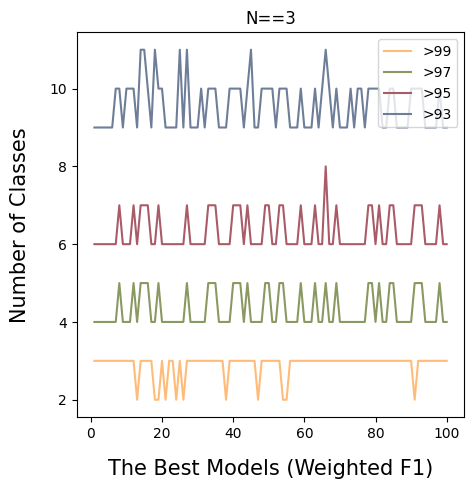

In [20]:
plot_line([list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1))],
          [model_analysis_N3_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')

#### Limiting Depth to 20

In [24]:
model_analysis_noLimit_N3 = model_analysis_noLimit_N3[model_analysis_noLimit_N3['depth'] < 20]

In [18]:
model_analysis_N3_BEST_100 = model_analysis_noLimit_N3.sort_values(by='Weighted_f1_FL', ascending=False).head(100)

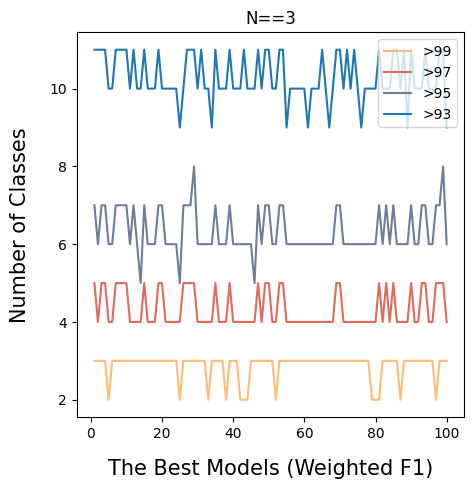

In [19]:
plot_line([list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1))],
          [model_analysis_N3_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')

#### Limiting depth to 15

In [20]:
model_analysis_noLimit_N3 = model_analysis_noLimit_N3[model_analysis_noLimit_N3['depth'] < 16]

In [21]:
model_analysis_N3_BEST_100 = model_analysis_noLimit_N3.sort_values(by='Weighted_f1_FL', ascending=False).head(100)

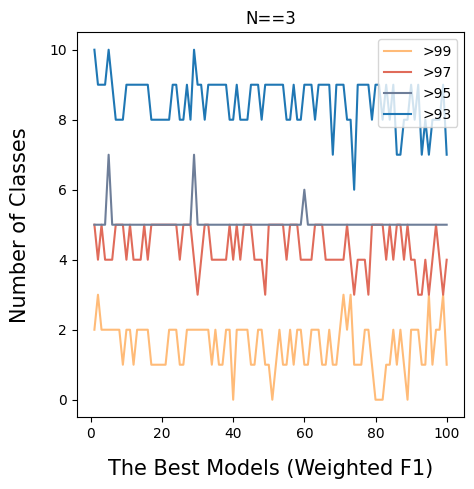

In [22]:
plot_line([list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1))],
          [model_analysis_N3_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')

### FITTING INTO ONE SWITCH

In [39]:
# model_analysis_noLimit_N3_FIT_ONE = model_analysis_noLimit_N3.loc[( ((model_analysis_noLimit_N3['tree'] == 5) & (model_analysis_noLimit_N3['tree'] < 5)) | ((model_analysis_noLimit_N3['tree'] == 4) & (model_analysis_noLimit_N3['tree'] < 6))  | ((model_analysis_noLimit_N3['tree'] == 3) & (model_analysis_noLimit_N3['tree'] < 8)) | ((model_analysis_noLimit_N3['tree'] == 2) & (model_analysis_noLimit_N3['tree'] < 10)) | ((model_analysis_noLimit_N3['tree'] == 1) & (model_analysis_noLimit_N3['tree'] < 16)))  ]

In [52]:
# model_analysis_N3_BEST_100 = model_analysis_noLimit_N3_FIT_ONE.sort_values(by='Weighted_f1_FL', ascending=False).head(1000)
# model_analysis_N3_BEST_100 = model_analysis_noLimit_N3_FIT_ONE[model_analysis_noLimit_N3_FIT_ONE['Weighted_f1_FL'] > 0.80].sort_values(by='Weighted_f1_FL', ascending=False).head(1000)

In [18]:
# plot_line([list(range(1, 1001, 1)), list(range(1, 1001, 1)), list(range(1, 1001, 1)), list(range(1, 1001, 1))],
#           [model_analysis_N3_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N3_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
#           ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')

#### The scores more than 80%

In [17]:
model_analysis_N3_BEST = model_analysis_noLimit_N3[model_analysis_noLimit_N3['Weighted_f1_FL'] > 0.85].sort_values(by='Weighted_f1_FL', ascending=False).head(3000)

In [18]:
class_occurences = {}
for cl_list in model_analysis_N3_BEST['succ_classes_FL_99'].to_list():
    for cl in cl_list:
        try:
            class_occurences[cl] = class_occurences[cl] + 1
        except:
            class_occurences[cl] = 1
print(class_occurences)

{'Light Bulbs LiFX Smart Bulb': 2998, 'Netatmo weather station': 2727, 'Smart Things': 2992}


In [ ]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
#
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
### FIX ###
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
###########

#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

In [ ]:
all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)

train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])

test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))

train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)

train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)

Num Labels:  24


In [16]:
# depth = 23
# n_tree = 17
# no_feats = 16
# leaf = 500
# feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
# print(feats)

In [17]:
# model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)

# num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
# print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


In [17]:
model_analysis_N3_BEST_20 = model_analysis_N3_BEST[model_analysis_N3_BEST['COUNT_succ_classes_FL_99'] > 2].head(20)

In [ ]:
model_analysis_N3_BEST_20.head(5)

In [18]:
feature_importance_ALL = pd.DataFrame()
feature_importance_ALL['feats'] = feats_all
feature_importance_ALL['importance'] = [0 for i in range (0, len(feats_all))]
feature_importance_ALL['occurence'] = [0 for i in range (0, len(feats_all))]

In [ ]:
number_of_leaves = []
feature_importances = {}
# class_success = {}

for index, row in model_analysis_N3_BEST_20.iterrows():
    depth = row['depth']
    n_tree = row['tree']
    n_feats = row['no_feats']
    feats = row['feats'].strip('[]').strip('\"\'\"').split('\', \'') 
    leaf = 500
    print('The model: (', depth, ', ', n_tree, ', ', n_feats, ')')
    model = get_model(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
    tree_count = -1
    for tree in model.estimators_:
        tree_count = tree_count + 1
        # cl_success = {}
        # feature_importance = pd.DataFrame(model.feature_importances_)
        # feature_importance.index = feats
        feature_importance = model.feature_importances_
        # feature_importances[tree_count] = feature_importance
        
        for f_ind in range(0,len(feats)):
            feat_name = feats[f_ind]
            feature_importance_ALL['importance'] = np.where(feature_importance_ALL['feats'] == feat_name, feature_importance_ALL['importance']+feature_importance[f_ind], feature_importance_ALL['importance'])
            feature_importance_ALL['occurence'] = np.where(feature_importance_ALL['feats'] == feat_name, feature_importance_ALL['occurence']+1, feature_importance_ALL['occurence'])

        y_pred = tree.predict(X_test[feats])
        
        y_test = [int(label) for label in y_test]
        y_pred = [int(label) for label in y_pred]

        class_report = classification_report(y_test, y_pred, labels=test_indices, target_names=test_labels, output_dict = True)
        
        # for cl_name in class_occurences.keys():
        #     cl_score = class_report[cl_name]['f1-score']
        #     cl_success[cl_name] = cl_score
            
        # cl_success['Overall'] = class_report['weighted avg']['f1-score']
            
        # class_success[tree_count] = cl_success

        

In [ ]:
feature_importance_ALL_sorted = feature_importance_ALL.sort_values(by='importance', ascending=False)

In [25]:
print(feature_importance_ALL_sorted[feature_importance_ALL_sorted['occurence'] > 300]['feats'].to_list())

['ip.len', 'tcp.window_size_value', 'udp.length', 'dstport', 'srcport', 'ip.ttl', 'tcp.hdr_len', 'Packet Length Total', 'Packet Length Mean', 'Max Packet Length', 'tcp.flags.rst', 'Flow IAT Mean', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min']


In [35]:
# plot_line([list(range(1, len(model_analysis_N3_BEST)+1, 1)), list(range(1, len(model_analysis_N3_BEST)+1, 1)), list(range(1, len(model_analysis_N3_BEST)+1, 1)), list(range(1, len(model_analysis_N3_BEST)+1, 1))],
#           [model_analysis_N3_BEST['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N3_BEST['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N3_BEST['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N3_BEST['COUNT_succ_classes_FL_93'].to_list()],
#           ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')

##### With only important features

In [15]:
model_analysis_limit_N3 = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_FEATSIMPORTANT_COPY.csv', sep=';')

In [16]:
threshold_score = 0.99
model_analysis_limit_N3['c_report_FL_99'] = model_analysis_limit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_limit_N3['succ_classes_FL_99'] = model_analysis_limit_N3['c_report_FL_99'].apply(find_successful_classes)
model_analysis_limit_N3['COUNT_succ_classes_FL_99'] = model_analysis_limit_N3['succ_classes_FL_99'].apply(count_succ_classes)

class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_limit_N3['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_limit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_limit_N3['score_Netatmo_Weather_station'] = model_analysis_limit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_limit_N3['score_Smart_Things'] = model_analysis_limit_N3['c_report_FL_99'].apply(get_score_of_classes)

In [18]:
model_analysis_limit_N3 = model_analysis_limit_N3[model_analysis_limit_N3['COUNT_succ_classes_FL_99']>2]

In [19]:
model_analysis_limit_N3.sort_values(by='no_feats').head(15)

,depth,tree,no_feats,N_Leaves,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,n_of_leaves,pkt_weighted_f1,...,Weighted_F1_PL,Micro_F1_PL,cl_report_FL,cl_report_PL,c_report_FL_99,succ_classes_FL_99,COUNT_succ_classes_FL_99,score_Light_Bulbs_LiFX_Smart_Bulb,score_Netatmo_Weather_station,score_Smart_Things
4463,16,12,9,500,0.753956,0.883164,0.882769,"['ip.len', 'tcp.window_size_value', 'udp.lengt...","[500, 500, 500, 500, 500, 500, 500, 500, 500, ...",0.853724,...,0.828391,0.831879,"{'Laptop': {'precision': 0.9526017550424147, '...","{'Laptop': {'precision': 0.9688183044725152, '...","{'Laptop': {'precision': 0.9526017550424147, '...","[Light Bulbs LiFX Smart Bulb, Netatmo weather ...",3,0.990466,0.990946,0.990116


In [20]:
model_analysis_NOlimit_N3 = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/model_analysis_N3_NoLimit_importantFeatures_3Classes.csv', sep=';')

In [21]:
threshold_score = 0.99
model_analysis_NOlimit_N3['c_report_FL_99'] = model_analysis_NOlimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_NOlimit_N3['succ_classes_FL_99'] = model_analysis_NOlimit_N3['c_report_FL_99'].apply(find_successful_classes)
model_analysis_NOlimit_N3['COUNT_succ_classes_FL_99'] = model_analysis_NOlimit_N3['succ_classes_FL_99'].apply(count_succ_classes)

class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_NOlimit_N3['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_NOlimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_NOlimit_N3['score_Netatmo_Weather_station'] = model_analysis_NOlimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_NOlimit_N3['score_Smart_Things'] = model_analysis_NOlimit_N3['c_report_FL_99'].apply(get_score_of_classes)

In [22]:
model_analysis_NOlimit_N3 = model_analysis_NOlimit_N3[model_analysis_NOlimit_N3['COUNT_succ_classes_FL_99'] == 3]

In [47]:
model_analysis_NOlimit_N3.sort_values(by=['tree','no_feats']).head(20)[['depth','tree','no_feats','score_Light_Bulbs_LiFX_Smart_Bulb','score_Netatmo_Weather_station','score_Smart_Things','Macro_f1_FL','Weighted_f1_FL','Micro_f1_FL']]

,depth,tree,no_feats,score_Light_Bulbs_LiFX_Smart_Bulb,score_Netatmo_Weather_station,score_Smart_Things,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL
334,27,1,5,0.990299,0.991970,0.990348,0.722113,0.855485,0.848281
365,29,1,6,0.997349,0.991970,0.994290,0.733724,0.885738,0.881054
231,20,1,7,0.998009,0.991970,0.990373,0.746499,0.878906,0.875599
246,21,1,7,0.999337,0.991970,0.996201,0.761000,0.892495,0.889977
157,15,1,8,0.996612,0.997261,0.990524,0.673273,0.828511,0.825816
202,18,1,8,0.998840,0.997261,0.994810,0.744632,0.886665,0.884959
232,20,1,8,0.999028,0.996926,0.993875,0.748707,0.884305,0.880712
247,21,1,8,0.996935,0.993722,0.991646,0.740592,0.889748,0.887211
262,22,1,8,0.998564,0.996758,0.992941,0.768268,0.890590,0.886881
277,23,1,8,0.997533,0.997261,0.992431,0.773925,0.896058,0.893333


In [34]:
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_noLimit_N3['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_noLimit_N3['score_Netatmo_Weather_station'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_noLimit_N3['score_Smart_Things'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)

In [35]:
model_analysis_noLimit_N3 = model_analysis_noLimit_N3[model_analysis_noLimit_N3['COUNT_succ_classes_FL_99']>2]

In [38]:
model_analysis_noLimit_N3['COUNT_succ_classes_FL_99'].value_counts()

COUNT_succ_classes_FL_99
3    10828
Name: count, dtype: int64

In [48]:
model_analysis_noLimit_N3.sort_values(by=['tree','no_feats']).head(20)[['depth','tree','no_feats','score_Light_Bulbs_LiFX_Smart_Bulb','score_Netatmo_Weather_station','score_Smart_Things','Macro_f1_FL','Weighted_f1_FL','Micro_f1_FL']]

,depth,tree,no_feats,score_Light_Bulbs_LiFX_Smart_Bulb,score_Netatmo_Weather_station,score_Smart_Things,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL
129,20,1,6,0.997681,0.991970,0.990603,0.719531,0.881363,0.877910
129,27,1,6,0.995506,0.991970,0.991954,0.764952,0.886228,0.881658
161,28,1,7,0.998344,0.991970,0.996622,0.733486,0.880315,0.876422
162,21,1,8,0.997799,0.996591,0.991417,0.771943,0.897478,0.894306
100,26,1,8,0.997792,0.995253,0.995251,0.757186,0.888814,0.885086
131,27,1,8,0.997522,0.991828,0.994082,0.756960,0.886373,0.883196
224,30,1,8,0.998528,0.996591,0.992925,0.758961,0.884214,0.880642
132,20,1,9,0.997792,0.997261,0.994136,0.770326,0.894891,0.891889
163,21,1,9,0.995654,0.997213,0.993297,0.764407,0.890982,0.890296
194,22,1,9,0.993069,0.991788,0.991621,0.694882,0.836092,0.831778


In [36]:
model_analysis_noLimit_N3.sort_values(by=['tree','no_feats']).head(20)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,pkt_macro_f1,pkt_weighted_f1,flw_macro_f1,...,COUNT_succ_classes_FL_97,c_report_FL_95,succ_classes_FL_95,COUNT_succ_classes_FL_95,c_report_FL_93,succ_classes_FL_93,COUNT_succ_classes_FL_93,score_Light_Bulbs_LiFX_Smart_Bulb,score_Netatmo_Weather_station,score_Smart_Things
129,20,1,6,0.719531,0.881363,0.877910,"['ip.len', 'srcport', 'tcp.window_size_value',...",0.688779,0.853918,0.765459,...,3,"{'Laptop': {'precision': 0.9822359572727347, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",5,"{'Laptop': {'precision': 0.9822359572727347, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",7,0.997681,0.991970,0.990603
129,27,1,6,0.764952,0.886228,0.881658,"['ip.len', 'tcp.window_size_value', 'srcport',...",0.756575,0.868071,0.816844,...,4,"{'Laptop': {'precision': 0.9877779123167256, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",5,"{'Laptop': {'precision': 0.9877779123167256, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",8,0.995506,0.991970,0.991954
161,28,1,7,0.733486,0.880315,0.876422,"['ip.len', 'srcport', 'udp.length', 'ip.ttl', ...",0.715319,0.850790,0.784361,...,3,"{'Laptop': {'precision': 0.9837289603352694, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",5,"{'Laptop': {'precision': 0.9837289603352694, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",8,0.998344,0.991970,0.996622
162,21,1,8,0.771943,0.897478,0.894306,"['tcp.hdr_len', 'ip.len', 'srcport', 'dstport'...",0.749675,0.876053,0.845069,...,4,"{'Laptop': {'precision': 0.9812532771788824, '...","[Samsung SmartCam, Amazon Echo, Belkin wemo mo...",6,"{'Laptop': {'precision': 0.9812532771788824, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",7,0.997799,0.996591,0.991417
100,26,1,8,0.757186,0.888814,0.885086,"['ip.len', 'srcport', 'ip.ttl', 'tcp.window_si...",0.722266,0.854846,0.827050,...,4,"{'Laptop': {'precision': 0.9903335688202842, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",6,"{'Laptop': {'precision': 0.9903335688202842, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",8,0.997792,0.995253,0.995251
131,27,1,8,0.756960,0.886373,0.883196,"['ip.len', 'tcp.window_size_value', 'srcport',...",0.735522,0.859214,0.831711,...,4,"{'Laptop': {'precision': 0.9780829391401064, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",5,"{'Laptop': {'precision': 0.9780829391401064, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",7,0.997522,0.991828,0.994082
224,30,1,8,0.758961,0.884214,0.880642,"['ip.ttl', 'dstport', 'ip.len', 'srcport', 'tc...",0.730822,0.855045,0.846434,...,3,"{'Laptop': {'precision': 0.9773931218615624, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",5,"{'Laptop': {'precision': 0.9773931218615624, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",7,0.998528,0.996591,0.992925
132,20,1,9,0.770326,0.894891,0.891889,"['ip.len', 'srcport', 'tcp.window_size_value',...",0.733375,0.861438,0.822371,...,4,"{'Laptop': {'precision': 0.9910100732521053, '...","[Samsung SmartCam, Amazon Echo, Belkin wemo mo...",6,"{'Laptop': {'precision': 0.9910100732521053, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",8,0.997792,0.997261,0.994136
163,21,1,9,0.764407,0.890982,0.890296,"['tcp.hdr_len', 'ip.len', 'srcport', 'dstport'...",0.733725,0.862628,0.858842,...,4,"{'Laptop': {'precision': 0.9681398358285614, '...","[Samsung SmartCam, Belkin wemo motion sensor, ...",5,"{'Laptop': {'precision': 0.9681398358285614, '...","[Laptop, Samsung SmartCam, Amazon Echo, Belkin...",8,0.995654,0.997213,0.993297
194,22,1,9,0.694882,0.836092,0.831778,"['srcport', 'ip.len', 'tcp.hdr_len', 'dstport'...",0.702539,0.816956,0.832336,...,3,"{'Laptop': {'precision': 0.9781509145896872, '...","[Belkin wemo motion sensor, Light Bulbs LiFX S...",4,"{'Laptop': {'precision': 0.9781509145896872, '...","[Laptop, Belkin wemo motion sensor, Light Bulb...",5,0.993069,0.991788,0.991621


#### N=2

In [56]:
file_names_N2 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_2pkts_D5-15_T1-20.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_2pkts_D5-19_T21-40.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_2pkts_D15-22_T1-20.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_2pkts_D20-30_T21-40.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_2pkts_D22-30_T1-20.csv',]

In [71]:
model_analysis_noLimit_N2 = read_csv(file_names_N2)

In [20]:
# model_analysis_noLimit_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [21]:
# model_analysis_noLimit_N2[(model_analysis_noLimit_N2['tree'] == 1) & (model_analysis_noLimit_N2['no_feats'] < 16)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [22]:
# model_analysis_noLimit_N2[(model_analysis_noLimit_N2['tree'] == 2) & (model_analysis_noLimit_N2['no_feats'] < 10)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [23]:
# model_analysis_noLimit_N2[(model_analysis_noLimit_N2['tree'] == 3) & (model_analysis_noLimit_N2['no_feats'] < 8)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [24]:
# model_analysis_noLimit_N2[(model_analysis_noLimit_N2['tree'] == 4) & (model_analysis_noLimit_N2['no_feats'] < 6)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [25]:
# model_analysis_noLimit_N2[(model_analysis_noLimit_N2['tree'] == 5) & (model_analysis_noLimit_N2['no_feats'] < 5)].sort_values(by='Weighted_f1_FL', ascending=False).head(2)

In [74]:
threshold_score = 0.99
model_analysis_noLimit_N2['c_report_FL_99'] = model_analysis_noLimit_N2['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N2['succ_classes_FL_99'] = model_analysis_noLimit_N2['c_report_FL_99'].apply(find_successful_classes)
model_analysis_noLimit_N2['COUNT_succ_classes_FL_99'] = model_analysis_noLimit_N2['succ_classes_FL_99'].apply(count_succ_classes)
#
threshold_score = 0.97
model_analysis_noLimit_N2['c_report_FL_97'] = model_analysis_noLimit_N2['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N2['succ_classes_FL_97'] = model_analysis_noLimit_N2['c_report_FL_97'].apply(find_successful_classes)
model_analysis_noLimit_N2['COUNT_succ_classes_FL_97'] = model_analysis_noLimit_N2['succ_classes_FL_97'].apply(count_succ_classes)
#
threshold_score = 0.95
model_analysis_noLimit_N2['c_report_FL_95'] = model_analysis_noLimit_N2['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N2['succ_classes_FL_95'] = model_analysis_noLimit_N2['c_report_FL_95'].apply(find_successful_classes)
model_analysis_noLimit_N2['COUNT_succ_classes_FL_95'] = model_analysis_noLimit_N2['succ_classes_FL_95'].apply(count_succ_classes)
#
threshold_score = 0.93
model_analysis_noLimit_N2['c_report_FL_93'] = model_analysis_noLimit_N2['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N2['succ_classes_FL_93'] = model_analysis_noLimit_N2['c_report_FL_93'].apply(find_successful_classes)
model_analysis_noLimit_N2['COUNT_succ_classes_FL_93'] = model_analysis_noLimit_N2['succ_classes_FL_93'].apply(count_succ_classes)

In [60]:
len(model_analysis_noLimit_N2)

26121

In [75]:
model_analysis_N2_BEST_100 = model_analysis_noLimit_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(100)

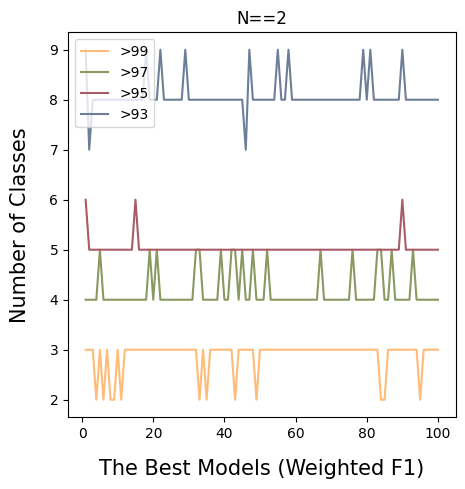

In [64]:
plot_line([list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1))],
          [model_analysis_N2_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==2')

#### Limiting to 20

In [65]:
model_analysis_noLimit_N2 = model_analysis_noLimit_N2[model_analysis_noLimit_N2['depth'] < 20]

In [66]:
model_analysis_N2_BEST_100 = model_analysis_noLimit_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(100)

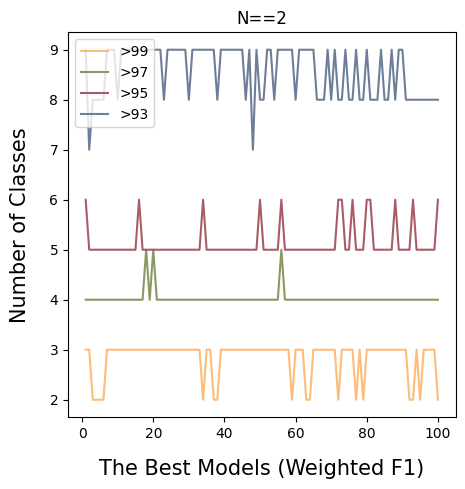

In [67]:
plot_line([list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1))],
          [model_analysis_N2_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==2')

#### Limiting to 15

In [68]:
model_analysis_noLimit_N2 = model_analysis_noLimit_N2[model_analysis_noLimit_N2['depth'] < 16]

In [69]:
model_analysis_N2_BEST_100 = model_analysis_noLimit_N2.sort_values(by='Weighted_f1_FL', ascending=False).head(100)

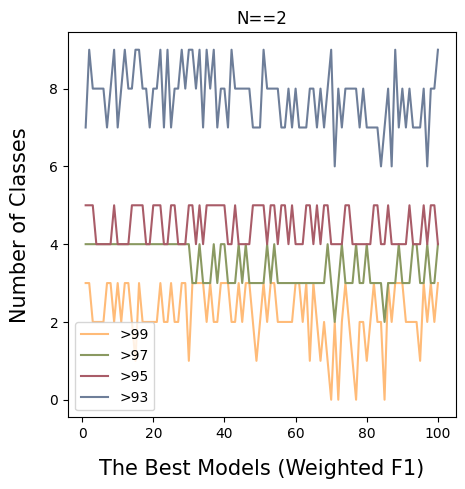

In [70]:
plot_line([list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1)), list(range(1, 101, 1))],
          [model_analysis_N2_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==2')

### FITTING INTO ONE SWITCH

In [84]:
model_analysis_noLimit_N2_FIT_ONE = model_analysis_noLimit_N2.loc[( ((model_analysis_noLimit_N2['tree'] == 5) & (model_analysis_noLimit_N2['tree'] < 5)) | ((model_analysis_noLimit_N2['tree'] == 4) & (model_analysis_noLimit_N2['tree'] < 6))  | ((model_analysis_noLimit_N2['tree'] == 3) & (model_analysis_noLimit_N2['tree'] < 8)) | ((model_analysis_noLimit_N2['tree'] == 2) & (model_analysis_noLimit_N2['tree'] < 10)) | ((model_analysis_noLimit_N2['tree'] == 1) & (model_analysis_noLimit_N2['tree'] < 16)))  ]
# model_analysis_N3_BEST_100 = model_analysis_noLimit_N3_FIT_ONE.sort_values(by='Weighted_f1_FL', ascending=False).head(1000)

In [85]:
model_analysis_N2_BEST_100 = model_analysis_noLimit_N2_FIT_ONE[model_analysis_noLimit_N2_FIT_ONE['Weighted_f1_FL'] > 0.80].sort_values(by='Weighted_f1_FL', ascending=False).head(1000)

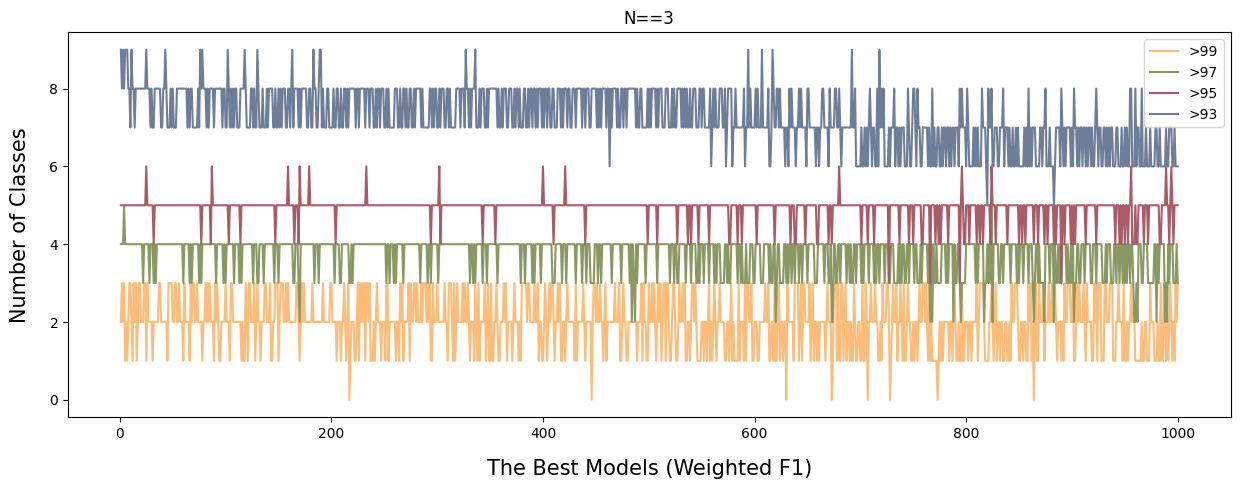

In [86]:
plot_line([list(range(1, 1001, 1)), list(range(1, 1001, 1)), list(range(1, 1001, 1)), list(range(1, 1001, 1))],
          [model_analysis_N2_BEST_100['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N2_BEST_100['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')

#### The scores more than 80%

In [87]:
model_analysis_N2_BEST = model_analysis_noLimit_N2[model_analysis_noLimit_N2['Weighted_f1_FL'] > 0.85].sort_values(by='Weighted_f1_FL', ascending=False).head(3000)

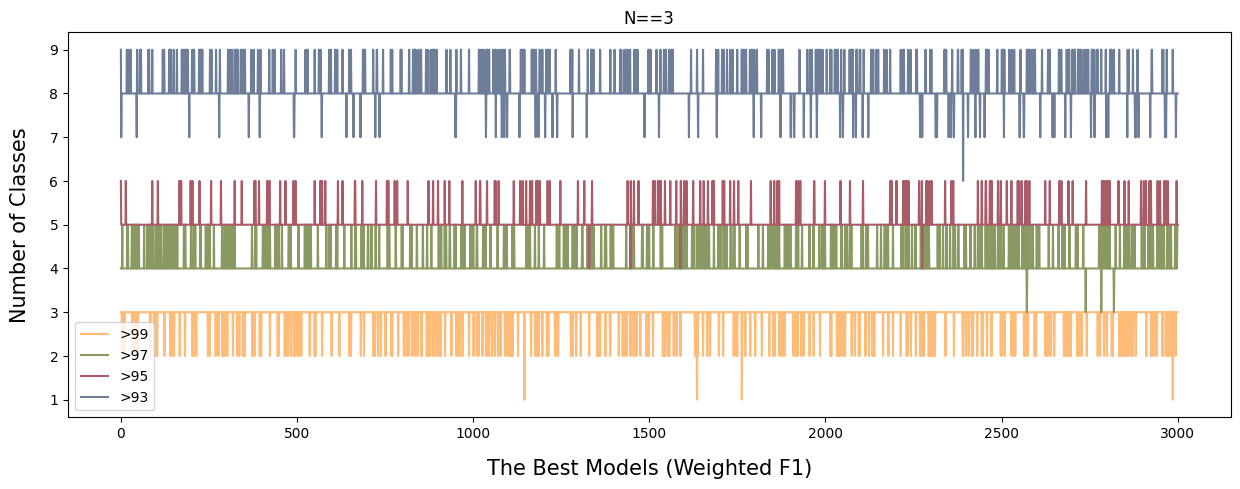

In [88]:
plot_line([list(range(1, len(model_analysis_N2_BEST)+1, 1)), list(range(1, len(model_analysis_N2_BEST)+1, 1)), list(range(1, len(model_analysis_N2_BEST)+1, 1)), list(range(1, len(model_analysis_N2_BEST)+1, 1))],
          [model_analysis_N2_BEST['COUNT_succ_classes_FL_99'].to_list(), model_analysis_N2_BEST['COUNT_succ_classes_FL_97'].to_list(), model_analysis_N2_BEST['COUNT_succ_classes_FL_95'].to_list(), model_analysis_N2_BEST['COUNT_succ_classes_FL_93'].to_list()],
          ['>99', '>97', '>95', '>93'], 'The Best Models (Weighted F1)', 'Number of Classes', 'N==3')